In [1]:
import pyDOE as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import GPy
import pickle
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import csv

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
# Plotting size
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

def scalex(col, min, max, xmax, xmin):
    range = xmax - xmin
    a = (col - xmin) / range
    return a * (max - min) + min

def rescale(xntd,min,max,x):
    xall = np.vstack((xntd,x))
    xalls = np.zeros((xall.shape[0],xall.shape[1]))
    
    # Scale values between min and max
    for i in range(xalls.shape[1]):
        xalls[:,i] = scalex(xall[:,i],min,max,x[:,i].max(),x[:,i].min())
        #xalls[:,i] = scale(xall[:,i],min,max)

    xntds = np.zeros((xntd.shape[0],xntd.shape[1]))

    for i in range(xntds.shape[1]):
        xntds[:,i] = xalls[0:(xntd.shape[0]),i]
        
    return xntds
    
def checkBound(xntd,x):
    for i in range(0,x.shape[1]):
        if xntd[:,i].max() > x[:,i].max():
            print("Max value for parameter in index %d out of training bounds."%(i))
        if xntd[:,i].min() < x[:,i].min():
            print("Min value for parameter in index %d out of training bounds."%(i))
            

In [8]:
## Constant things
eps = 10.**-6
param_n = 4
loc = "/home/jbarsima/Desktop/GP_Adipociyte_Size/adip_size/"
#loc = "/scratch/bell/jbarsima/adip_size/"

## Load data 5%

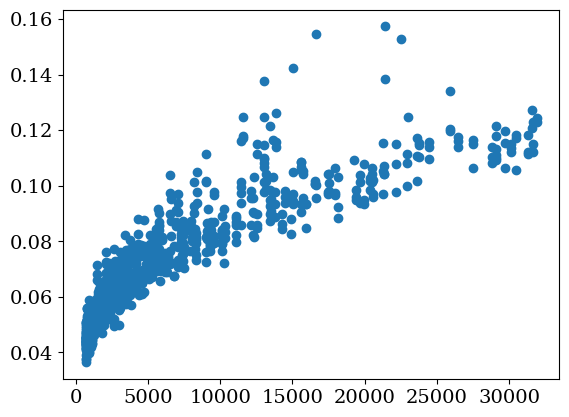

In [9]:
# Load deformed + eps configuration
Xplus5 = np.loadtxt(loc+'RVE_Psi_plus_1p05.csv', delimiter=',', unpack=True) # Material parameters probed
Xplus5 = Xplus5.transpose()


# Load deformed - eps configuration
Xminus5 = np.loadtxt(loc+'RVE_Psi_minus_1p05.csv', delimiter=',', unpack=True) # Material parameters probed
Xminus5 = Xminus5.transpose()


#X: D, Dstd, 1-S, Sstd, Psi, Psi Vol, Psi Area, Psi edge, Volume, Cells

xplus5 = Xplus5[:,0:4] #D, Dstd, S, Sstd
xplus5[:,2] = 1 - xplus5[:,2] 
psi_plus5 = Xplus5[:,4] #Psi plus total
psi_plus5 = psi_plus5.reshape(-1,1)
ncell5 = Xplus5[:,-1].reshape(-1,1)

xminus5 = Xminus5[:,0:4] #D, Dstd, S, Sstd
xminus5[:,2] = 1 - xminus5[:,2] 
psi_minus5 = Xminus5[:,4] #Psi minus total
psi_minus5 = psi_minus5.reshape(-1,1)
Vf5 = Xminus5[:,-2].reshape(-1,1) #Actual final volume
#ncell5 = Xminus5[:,-1].reshape(-1,1)

# get the number of rows in the array
num_rows = xplus5.shape[0]

# create a column vector of size nx1 filled with 1.05
new_col = np.ones((num_rows, 1)) * 1.05

# append the new column to the original array
xplus5 = np.append(xplus5, new_col, axis=1)

lam5 = 1.05
J5 = lam5**3
len_plus5 = len(psi_plus5)
dpsidlam5 = (psi_plus5[:len_plus5] - psi_minus5[:len_plus5])/(2*eps) #Central difference
y5 = (J5**-1)*lam5*dpsidlam5 #Stress

# Clean bad data
xy5 = np.hstack((xplus5,ncell5,y5))
mask = xy5[:, -1] > 0.160
x5 = cp.deepcopy(xy5[~mask])

yclean5 = cp.deepcopy(x5[:,-1])
xclean5 = cp.deepcopy(x5[:,:-2])
ncellclean5 = cp.deepcopy(x5[:,-2])

plt.plot(ncellclean5/0.5**3,yclean5,'o')

## Load data 10%

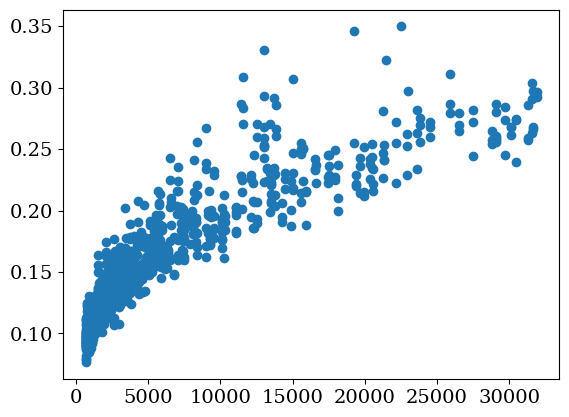

In [10]:
# Load deformed + eps configuration
Xplus10 = np.loadtxt(loc+'RVE_Psi_plus_1p10.csv', delimiter=',', unpack=True) # Material parameters probed
Xplus10 = Xplus10.transpose()


# Load deformed - eps configuration
Xminus10 = np.loadtxt(loc+'RVE_Psi_minus_1p10.csv', delimiter=',', unpack=True) # Material parameters probed
Xminus10 = Xminus10.transpose()


#X: D, Dstd, 1-S, Sstd, Psi, Psi Vol, Psi Area, Psi edge, Volume, Cells

xplus10 = Xplus10[:,0:4] #D, Dstd, S, Sstd
xplus10[:,2] = 1 - xplus10[:,2] 
psi_plus10 = Xplus10[:,4] #Psi plus total
psi_plus10 = psi_plus10.reshape(-1,1)
ncell10 = Xplus10[:,-1].reshape(-1,1)

xminus10 = Xminus10[:,0:4] #D, Dstd, S, Sstd
xminus10[:,2] = 1 - xminus10[:,2] 
psi_minus10 = Xminus10[:,4] #Psi minus total
psi_minus10 = psi_minus10.reshape(-1,1)
Vf10 = Xminus10[:,-2].reshape(-1,1) #Actual final volume
ncell10 = Xminus10[:,-1].reshape(-1,1)

# get the number of rows in the array
num_rows = xminus10.shape[0]

# create a column vector of size nx1 filled with 1.010
new_col = np.ones((num_rows, 1)) * 1.10

# append the new column to the original array
xminus10 = np.append(xminus10, new_col, axis=1)

lam10 = 1.10
J10 = lam10**3
len_minus10 = len(psi_minus10)
dpsidlam10 = (psi_plus10[:len_minus10] - psi_minus10)/(2*eps) #Central difference
y10 = (J10**-1)*lam10*dpsidlam10 #Stress

# Clean bad data
xy10 = np.hstack((xminus10,ncell10,y10))
mask = xy10[:, -1] > 0.35
x10 = cp.deepcopy(xy10[~mask])

yclean10 = cp.deepcopy(x10[:,-1])
xclean10 = cp.deepcopy(x10[:,:-2])
ncellclean10 = cp.deepcopy(x10[:,-2])

plt.plot(ncellclean10/0.5**3,yclean10,'o')


## Load data 15%

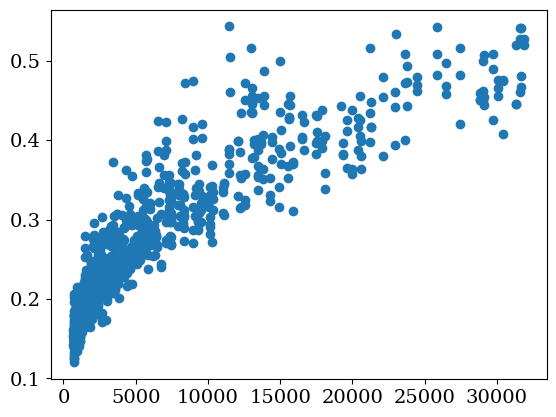

In [11]:
# Load deformed + eps configuration
Xplus15 = np.loadtxt(loc+'RVE_Psi_plus_1p15.csv', delimiter=',', unpack=True) # Material parameters probed
Xplus15 = Xplus15.transpose()


# Load deformed - eps configuration
Xminus15 = np.loadtxt(loc+'RVE_Psi_minus_1p15.csv', delimiter=',', unpack=True) # Material parameters probed
Xminus15 = Xminus15.transpose()


#X: D, Dstd, 1-S, Sstd, Psi, Psi Vol, Psi Area, Psi edge, Volume, Cells

xplus15 = Xplus15[:,0:4] #D, Dstd, S, Sstd
xplus15[:,2] = 1 - xplus15[:,2] 
psi_plus15 = Xplus15[:,4] #Psi plus total
psi_plus15 = psi_plus15.reshape(-1,1)
ncell15 = Xplus15[:,-1].reshape(-1,1)

xminus15 = Xminus15[:,0:4] #D, Dstd, S, Sstd
xminus15[:,2] = 1 - xminus15[:,2] 
psi_minus15 = Xminus15[:,4] #Psi minus total
psi_minus15 = psi_minus15.reshape(-1,1)
Vf15 = Xminus15[:,-2].reshape(-1,1) #Actual final volume
ncell15 = Xminus15[:,-1].reshape(-1,1)

# get the number of rows in the array
num_rows = xminus15.shape[0]

# create a column vector of size nx1 filled with 1.015
new_col = np.ones((num_rows, 1)) * 1.15

# append the new column to the original array
xminus15 = np.append(xminus15, new_col, axis=1)

lam15 = 1.15
J15 = lam15**3
dpsidlam15 = (psi_plus15 - psi_minus15)/(2*eps) #Central difference
y15 = (J15**-1)*lam15*dpsidlam15 #Stress

# Clean bad data
xy15 = np.hstack((xminus15,ncell15,y15))
mask = xy15[:, -1] > 0.55
x15 = cp.deepcopy(xy15[~mask])

yclean15 = cp.deepcopy(x15[:,-1])
xclean15 = cp.deepcopy(x15[:,:-2])
ncellclean15 = cp.deepcopy(x15[:,-2])

plt.plot(ncellclean15/0.5**3,yclean15,'o')

## Load data 20%

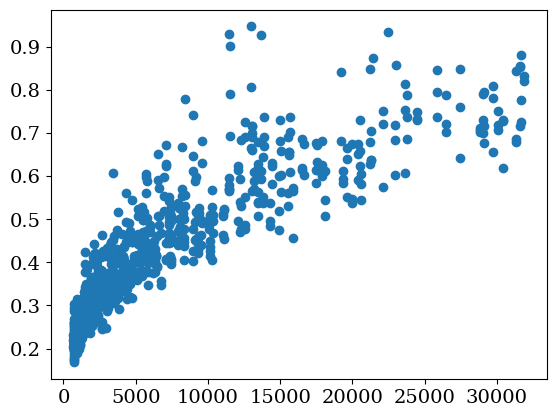

In [12]:
# Load deformed + eps configuration
Xplus20 = np.loadtxt(loc+'RVE_Psi_plus_1p20.csv', delimiter=',', unpack=True) # Material parameters probed
Xplus20 = Xplus20.transpose()


# Load deformed - eps configuration
Xminus20 = np.loadtxt(loc+'RVE_Psi_minus_1p20.csv', delimiter=',', unpack=True) # Material parameters probed
Xminus20 = Xminus20.transpose()


#X: D, Dstd, 1-S, Sstd, Psi, Psi Vol, Psi Area, Psi edge, Volume, Cells

xplus20 = Xplus20[:,0:4] #D, Dstd, S, Sstd
xplus20[:,2] = 1 - xplus20[:,2] 
psi_plus20 = Xplus20[:,4] #Psi plus total
psi_plus20 = psi_plus20.reshape(-1,1)
ncell20 = Xplus20[:,-1].reshape(-1,1)

xminus20 = Xminus20[:,0:4] #D, Dstd, S, Sstd
xminus20[:,2] = 1 - xminus20[:,2] 
psi_minus20 = Xminus20[:,4] #Psi minus total
psi_minus20 = psi_minus20.reshape(-1,1)
Vf20 = Xminus20[:,-2].reshape(-1,1) #Actual final volume
#ncell20 = Xminus20[:,-1].reshape(-1,1)

# get the number of rows in the array
num_rows = xplus20.shape[0]

# create a column vector of size nx1 filled with 1.020
new_col = np.ones((num_rows, 1)) * 1.20

# append the new column to the original array
xplus20 = np.append(xplus20, new_col, axis=1)

lam20 = 1.20
J20 = lam20**3
dpsidlam20 = (psi_plus20 - psi_minus20)/(2*eps) #Central difference
y20 = (J20**-1)*lam20*dpsidlam20 #Stress

# Clean bad data
xy20 = np.hstack((xplus20,ncell20,y20))
mask = xy20[:, -1] > 1.1
x20 = cp.deepcopy(xy20[~mask])

yclean20 = cp.deepcopy(x20[:,-1])
xclean20 = cp.deepcopy(x20[:,:-2])
ncellclean20 = cp.deepcopy(x20[:,-2])

plt.plot(ncellclean20/0.5**3,yclean20,'o')

## Combine all into one array

In [13]:
xminus1 = cp.deepcopy(xclean15)
xminus1[:,-1] = np.ones((xminus1.shape[0])) * 1.0
y1 = np.zeros(((yclean15.reshape(-1,1)).shape[0],(yclean15.reshape(-1,1)).shape[1]))
xall = np.vstack((xminus1,xclean5,xclean10,xclean15,xclean20))
yall = np.vstack((y1,yclean5.reshape(-1,1),yclean10.reshape(-1,1),yclean15.reshape(-1,1),yclean20.reshape(-1,1)))/50

In [14]:
print(xall.max())
print(yall.max())
#xy = np.hstack((xall,yall))
# get a boolean mask of rows where the last column value is greater than 1
#mask = xy[:, -1] > 1.3
# use boolean indexing to remove rows where the last column value is greater than 1
#xall = cp.deepcopy(xy[~mask])

#yclean = cp.deepcopy(xall[:,-1])
#xclean = cp.deepcopy(xall[:,:-1])

1.2
0.01894159798685828


## Train GP

In [76]:
# Scale X values between a and b
a = 0.
b = 1.
xs = np.zeros((xall.shape[0],xall.shape[1]))

for i in range(xs.shape[1]):
    xs[:,i] = scale(xall[:,i],a,b)

Xtrain, Xtest, ytrain, ytest = train_test_split(xall, yall, train_size=0.45, random_state=27)
print(len(Xtrain))
print(len(Xtest))

2359
2885


In [57]:
xall

array([[0.07097233, 0.00483311, 0.85466481, 0.0015883 , 1.        ],
       [0.03605914, 0.01869048, 0.94951452, 0.02271821, 1.        ],
       [0.09062005, 0.01654122, 0.90687478, 0.00749711, 1.        ],
       ...,
       [0.11124485, 0.00178766, 0.90577121, 0.00539886, 1.2       ],
       [0.13205272, 0.00603346, 0.7660841 , 0.03783104, 1.2       ],
       [0.04328266, 0.01336066, 0.89702625, 0.02832548, 1.2       ]])

## GP

In [ ]:
# RBF
ls = 1
kernel = GPy.kern.RBF(input_dim=xs.shape[1], ARD=True, lengthscale=[ls,ls,ls,ls,ls]) #When using scaled values
#print(k)

# Set up model
m = GPy.models.GPRegression(Xtrain,ytrain.reshape(-1,1),kernel,mean_function=None)
#print(m_count)

# Plot the unfit version
#fig = m.plot()

m.optimize(messages=True,max_f_eval=1000)
#m.optimize_restarts(num_restarts = 10)
print(m)

In [ ]:
m.kern.lengthscale
#C = kernel.K(Xtest,Xtest)
#plt.matshow(C)

In [ ]:
### RUN ONLY IF TRAIN GP AGAIN
#with open("RVE_geo.dump" , "wb") as f:
#     pickle.dump(m, f) 

In [18]:
m = pickle.load(open("RVE_geo.dump","rb"))

0.00019246047378466136


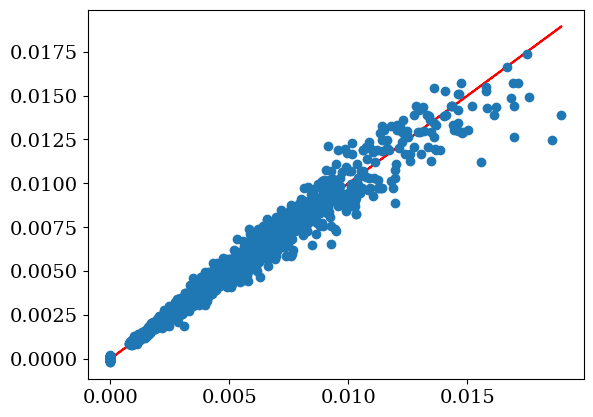

In [19]:
ypred,var = m.predict(Xtest)

j = 0

yp = ypred + 1.96*np.sqrt(var)
ym = ypred - 1.96*np.sqrt(var)

print(np.sqrt(np.sum(ypred-ytest)**2/len(ypred)))
plt.plot(ytest,ytest,'-r')
plt.plot(ytest,ypred,'o')
#plt.xlim([0., 1])
#plt.ylim([0., 1])
#plt.plot(ypred,ypred,'-g')

[0.0825 0.0105 0.85   0.0205 1.15  ]


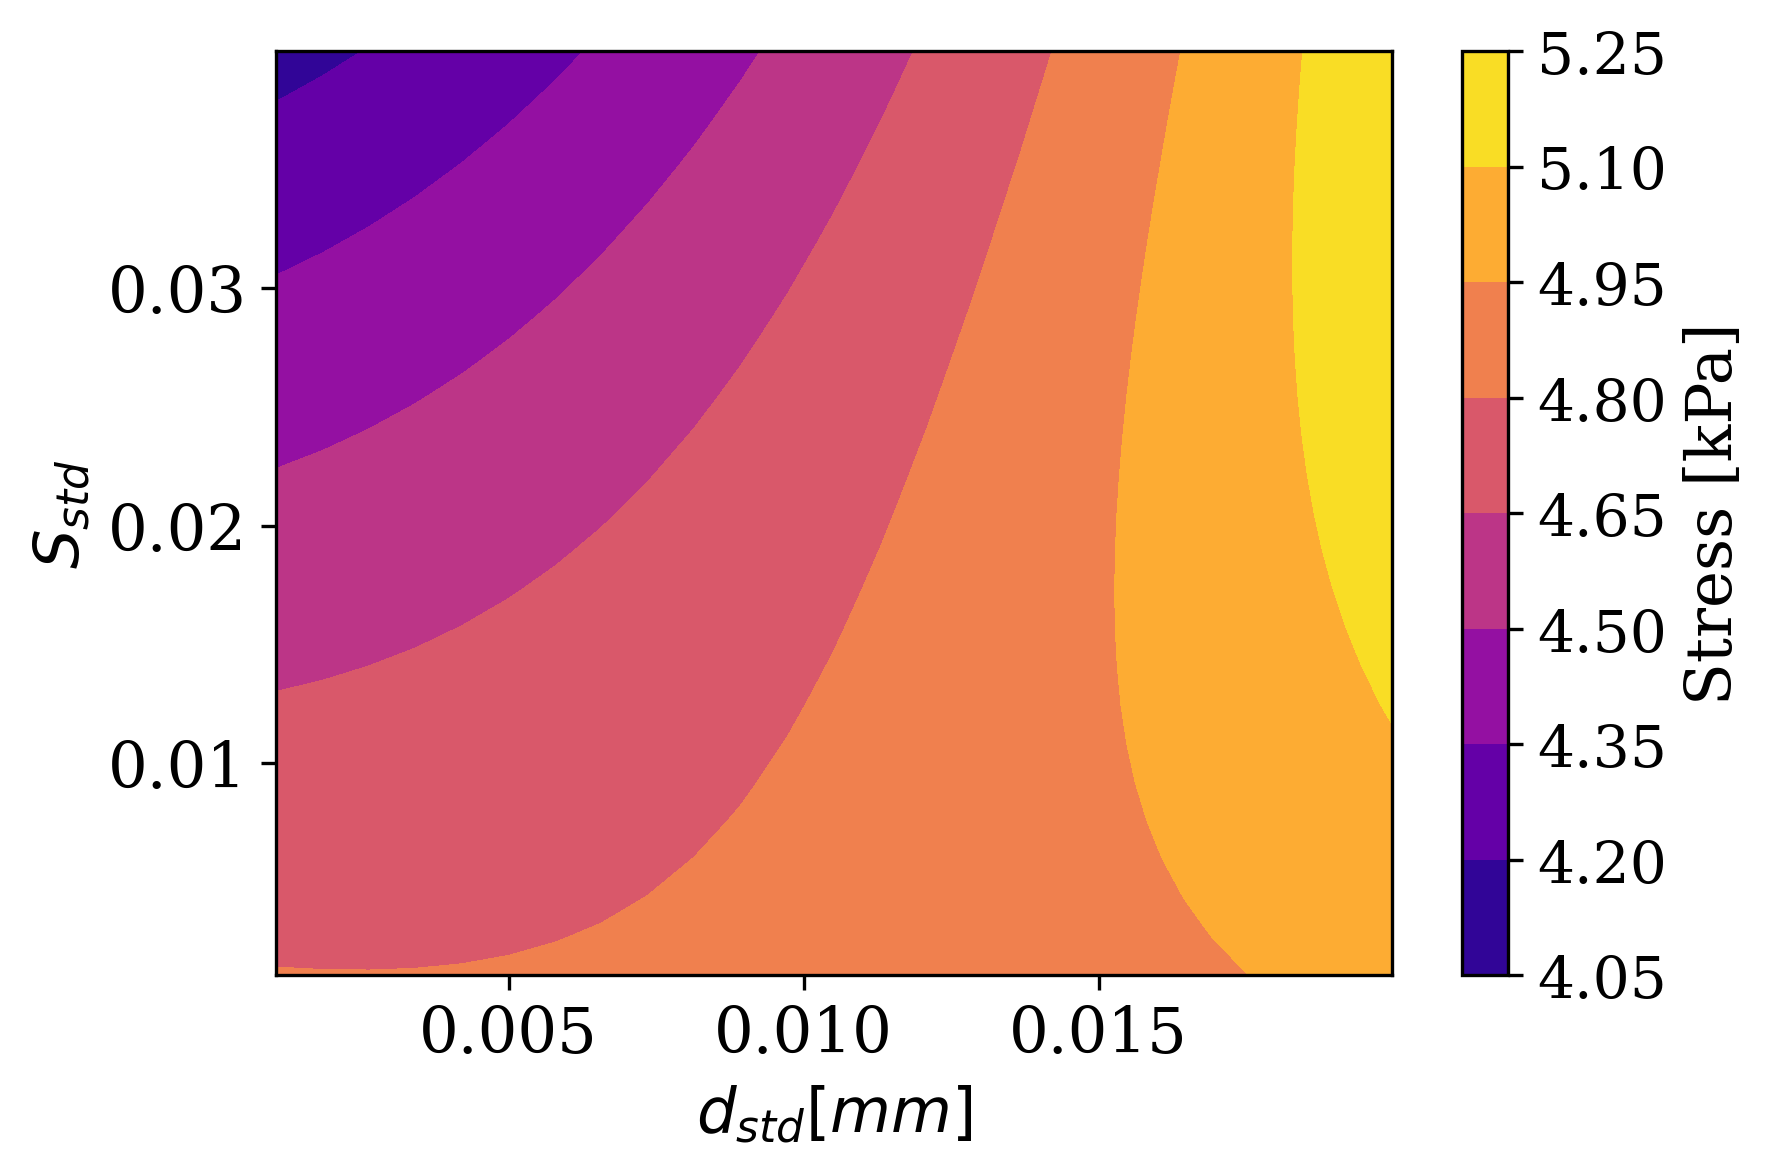

In [156]:
###### NEW CONTOURS
#Define the input array Xtest
#p = 2
#Xcont = cp.deepcopy(Xtest[p,:])
Xcont = np.array([82.5*10.**-3.,10.5*10.**-3,.85,0.0205,1.15]) #Using mean
# Choose for n or k
# d = 0, dstd = 1, S = 2, Sstd = 3
n = 1
k = 3

print(Xcont)

Ns = 25

# Create a contour plot based on the model predictions for Xtest
dx = np.linspace(a, b, Ns)
dy = np.linspace(a, b, Ns)
Xplot = np.linspace(xall[:,n].min(),xall[:,n].max(),Ns)
Yplot = np.linspace(xall[:,k].min(),xall[:,k].max(),Ns)
X, Y = np.meshgrid(dx, dy)
DX, DY = np.meshgrid(Xplot, Yplot)
Z = np.zeros((len(dx), len(dy)))

for i in range(len(dx)):
    for j in range(len(dy)):
        Xcont[n] = DX[i,j]
        Xcont[k] = DY[i,j]
        ycontour, oo = m.predict(Xcont.reshape(1,5))
        Z[i, j] = ycontour
        #print(Xcont.reshape(1,5))
        #print(Z[i,j])
        #print(1.96*np.sqrt(oo)*1000)
        

plt.contourf(DX, DY, Z*1000, cmap='plasma')
#plt.contourf(DX, DY, Z*1000, cmap='plasma')
cb = plt.colorbar(label='Stress [kPa]')
cb.ax.yaxis.set_minor_formatter(ticker.NullFormatter())

### x-labels
if n == 0:
    plt.xlabel('$d [mm]$', fontsize=15)
elif n == 1:
    plt.xlabel('$d_{std} [mm]$', fontsize=15)
elif n == 2:
    plt.xlabel('$S$', fontsize=15)
else:
    plt.xlabel('$S_{std}$', fontsize=15)

### y-labels
### x-labels
if k == 0:
    plt.ylabel('$d [mm]$', fontsize=15)
elif k == 1:
    plt.ylabel('$d_{std} [mm]$', fontsize=15)
elif k == 2:
    plt.ylabel('$S$', fontsize=15)
else:
    plt.ylabel('$S_{std}$', fontsize=15)
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Set the font size of the colorbar label
cb.ax.set_ylabel('Stress [kPa]', fontsize=15)
# Set the size and DPI of the saved image
fig = plt.gcf()
fig.set_size_inches(6, 4) # 6x4 inches
fig.set_dpi(300) # 300 DPI

# Save the plot as a PNG image
#plt.savefig('dstdSstd_stress_contour.png', bbox_inches='tight')
plt.show()

In [48]:
### Testing zone
XD_Plot = np.zeros((1,5))
XD_Plot[0,0] = 0.03736042
XD_Plot[0,1] = 0.01726532
XD_Plot[0,2] = 0.9
XD_Plot[0,3] = 0.02
XD_Plot[0,4] = 1.2
S_pred,var = m.predict(XD_Plot)
print(S_pred)

[[0.0131148]]


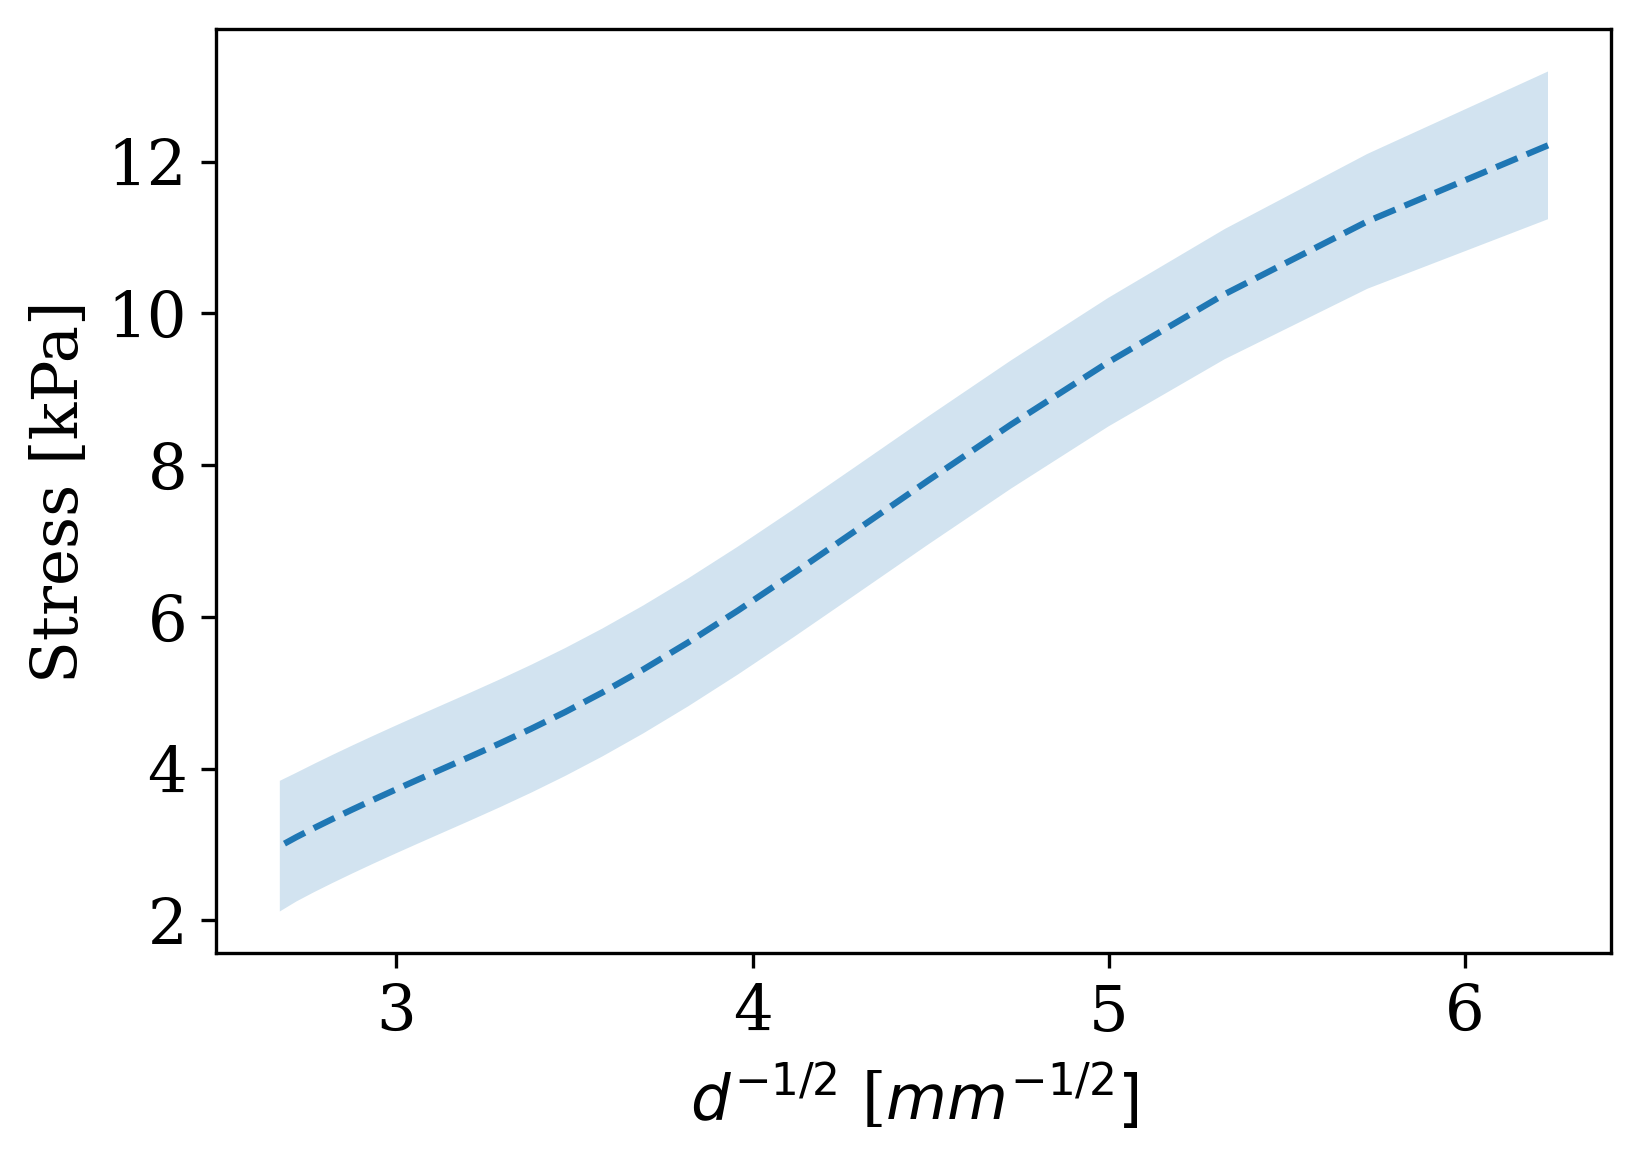

In [51]:
Dplot = np.linspace(xall[:,0].min(),xall[:,0].max(),Ns)
XD_Plot = np.zeros((len(Dplot),5))
#Dstd_ = Xtest[p,1]
#S_ = Xtest[p,2]
#Sstd_ = Xtest[p,3]
#stre_ = Xtest[p,4]
Dstd_ = 10.5*10.**-3
S_ = .85
Sstd_ = 0.0205
stre_ = 1.15
#Xcont = np.array([82.5*10.**-3.,10.5*10.**-3,.85,0.0205,1.15]) #Using mean
for i in range(len(XD_Plot)):
    XD_Plot[i,0] = Dplot[i]
    XD_Plot[i,1] = Dstd_
    XD_Plot[i,2] = S_
    XD_Plot[i,3] = Sstd_
    XD_Plot[i,4] = stre_
    
S_pred,var = m.predict(XD_Plot)
splus = S_pred+1.96*np.sqrt(var)
sminus = S_pred-1.96*np.sqrt(var)
plt.plot(XD_Plot[:,0]**-0.5,S_pred*1000,'--')
plt.fill_between(XD_Plot[:,0]**-0.5,splus[:,0]*1000,sminus[:,0]*1000,alpha=0.2,label='95% confidence interval')
plt.xlabel('$d^{-1/2}$ [$mm^{-1/2}]$',fontsize=15)
plt.ylabel('Stress [kPa]',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend()
# Set the size and DPI of the saved image
fig = plt.gcf()
fig.set_size_inches(6, 4) # 6x4 inches
fig.set_dpi(300) # 300 DPI
# Save the plot as a PNG image
plt.savefig('cellSize_stress.png', bbox_inches='tight')
plt.show()

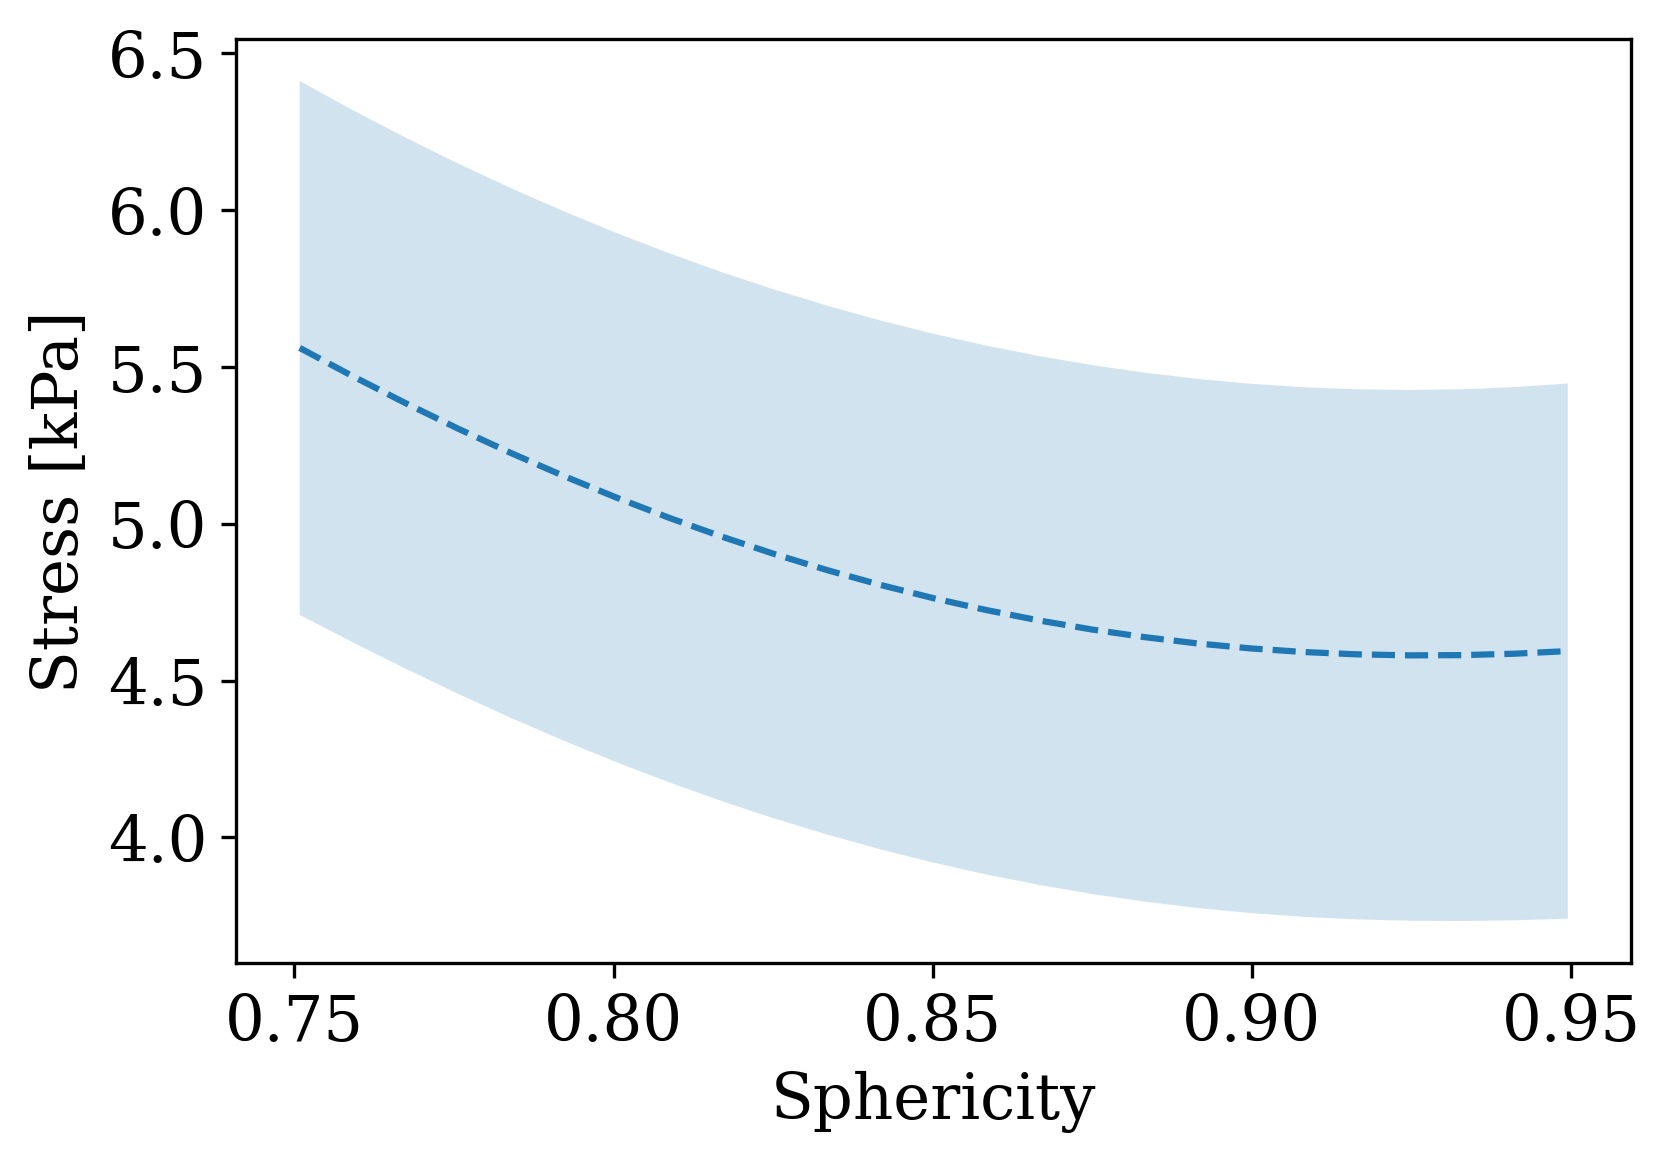

In [52]:
Splot = np.linspace(xall[:,2].min(),xall[:,2].max(),Ns)
XS_Plot = np.zeros((len(Splot),5))
#D_ = Xtest[p,0]
#Dstd_ = Xtest[p,1]
#Sstd_ = Xtest[p,3]
#stre_ = Xtest[p,4]
D_ = 82.5*10.**-3.
Dstd_ = 10.5*10.**-3
Sstd_ = 0.0205
stre_ = 1.15
#Xcont = np.array([82.5*10.**-3.,10.5*10.**-3,.85,0.0205,1.15]) #Using mean
for i in range(len(XS_Plot)):
    XS_Plot[i,0] = D_
    XS_Plot[i,1] = Dstd_
    XS_Plot[i,2] = Splot[i]
    XS_Plot[i,3] = Sstd_
    XS_Plot[i,4] = stre_
    
S_pred,var = m.predict(XS_Plot)
splus = S_pred+1.96*np.sqrt(var)
sminus = S_pred-1.96*np.sqrt(var)
plt.plot(XS_Plot[:,2],S_pred*1000,'--')
plt.fill_between(XS_Plot[:,2],splus[:,0]*1000,sminus[:,0]*1000,alpha=0.2,label='95% confidence interval')
plt.xlabel('Sphericity',fontsize=15)
plt.ylabel('Stress [kPa]',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend()
# Set the size and DPI of the saved image
fig = plt.gcf()
fig.set_size_inches(6, 4) # 6x4 inches
fig.set_dpi(300) # 300 DPI
# Save the plot as a PNG image
plt.savefig('sphericity_stress.png', bbox_inches='tight')
plt.show()

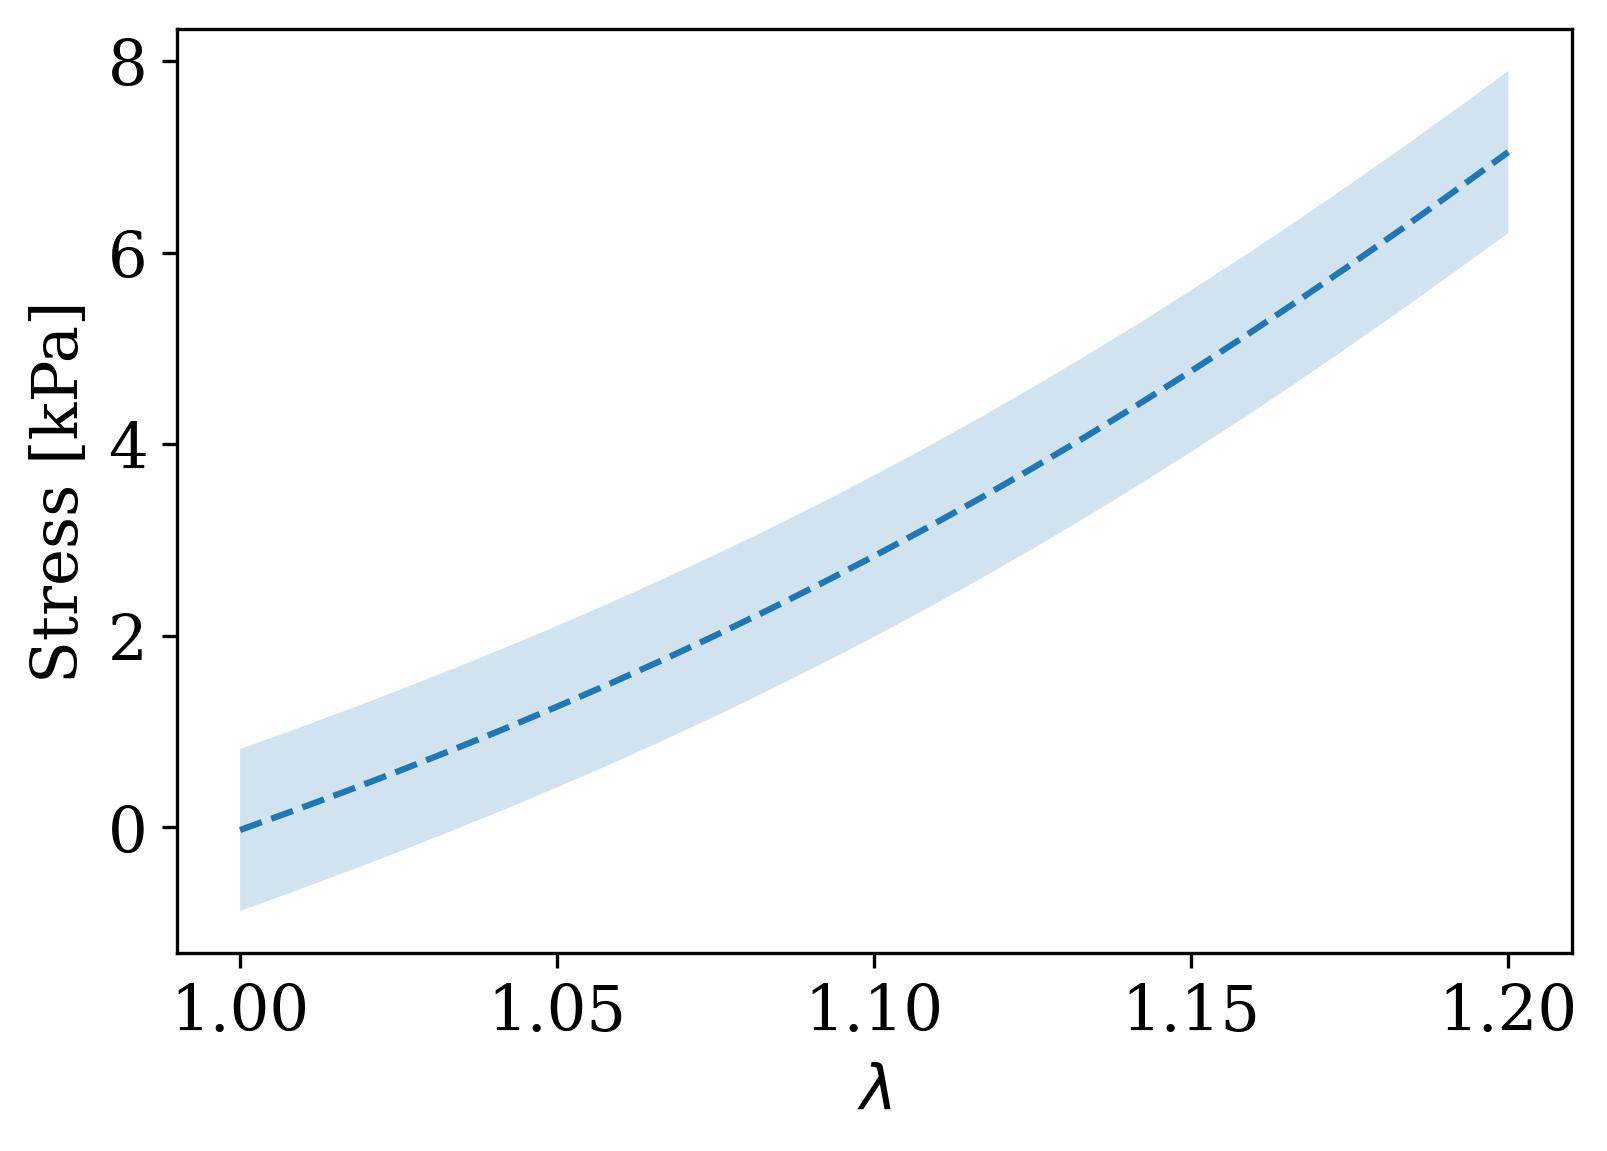

In [53]:
Strplot = np.linspace(xall[:,4].min(),xall[:,4].max(),Ns)
XStr_Plot = np.zeros((len(Strplot),5))
#D_ = 0.0752#Xtest[p,0]
#Dstd_ = 0.002428#Xtest[p,1]
#S_ = 0.82#Xtest[p,2]
#Sstd_ = 0.0305513#Xtest[p,3]
D_ = 82.5*10.**-3
Dstd_ = 10.5*10.**-3
S_ = .85
Sstd_ = 0.0205
#Xcont = np.array([82.5*10.**-3.,10.5*10.**-3,.85,0.0205,1.15]) #Using mean

for i in range(len(Strplot)):
    XStr_Plot[i,0] = D_
    XStr_Plot[i,1] = Dstd_
    XStr_Plot[i,2] = S_
    XStr_Plot[i,3] = Sstd_
    XStr_Plot[i,4] = Strplot[i]
    
S_pred,var = m.predict(XStr_Plot)
splus = S_pred+1.96*np.sqrt(var)
sminus = S_pred-1.96*np.sqrt(var)
plt.plot(XStr_Plot[:,4],S_pred*1000,'--')
plt.fill_between(XStr_Plot[:,4],splus[:,0]*1000,sminus[:,0]*1000,alpha=0.2,label='95% confidence interval')
plt.xlabel('$\lambda$',fontsize=15)
plt.ylabel('Stress [kPa]',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend()
# Set the size and DPI of the saved image
fig = plt.gcf()
fig.set_size_inches(6, 4) # 6x4 inches
fig.set_dpi(300) # 300 DPI
# Save the plot as a PNG image
plt.savefig('stretch_stress.png', bbox_inches='tight')
plt.show()

In [ ]:
Str_palo = np.linspace(xall[:,4].min(),xall[:,4].max(),Ns)
XStr_palo = np.zeros((len(Str_palo),5))
D_ = 0.0752#Xtest[p,0]
Dstd_ = 0.002428#Xtest[p,1]
S_ = 0.82#Xtest[p,2]
Sstd_ = 0.0305513#Xtest[p,3]
for i in range(len(Str_palo)):
    XStr_palo[i,0] = D_
    XStr_palo[i,1] = Dstd_
    XStr_palo[i,2] = S_
    XStr_palo[i,3] = Sstd_
    XStr_palo[i,4] = Str_palo[i]
S_palo,var_palo = m.predict(XStr_palo)
splus_palo = S_palo+1.96*np.sqrt(var_palo)
sminus_palo = S_palo-1.96*np.sqrt(var_palo)
    
Str_hon1 = np.linspace(xall[:,4].min(),xall[:,4].max(),Ns)
XStr_hon1 = np.zeros((len(Str_hon1),5))
D_ = 0.0596#Xtest[p,0]
#D_ = 0.13994479
Dstd_ = 0.0078#Xtest[p,1]
S_ = 0.82#Xtest[p,2]
Sstd_ = 0.0305513#Xtest[p,3]
for i in range(len(Str_hon1)):
    XStr_hon1[i,0] = D_
    XStr_hon1[i,1] = Dstd_
    XStr_hon1[i,2] = S_
    XStr_hon1[i,3] = Sstd_
    XStr_hon1[i,4] = Str_hon1[i]
S_hon1,var_hon1 = m.predict(XStr_hon1)
splus_hon1 = S_hon1+1.96*np.sqrt(var_hon1)
sminus_hon1 = S_hon1-1.96*np.sqrt(var_hon1)
    
    
Str_hon2 = np.linspace(xall[:,4].min(),xall[:,4].max(),Ns)
XStr_hon2 = np.zeros((len(Str_hon2),5))
D_ = 0.1056#Xtest[p,0]
Dstd_ = 0.0147#Xtest[p,1]
S_ = 0.82#Xtest[p,2]
Sstd_ = 0.0305513#Xtest[p,3]
for i in range(len(Str_hon2)):
    XStr_hon2[i,0] = D_
    XStr_hon2[i,1] = Dstd_
    XStr_hon2[i,2] = S_
    XStr_hon2[i,3] = Sstd_
    XStr_hon2[i,4] = Str_hon2[i]
S_hon2,var_hon2 = m.predict(XStr_hon2)
splus_hon2 = S_hon2+1.96*np.sqrt(var_hon2)
sminus_hon2 = S_hon2-1.96*np.sqrt(var_hon2)

plt.plot(XStr_hon1[:,4],S_hon1*1000,'-',color='peru',label='$d$ = 59.6 $\pm$ 7.8 $\mu m$ (Honecker et al, 2021)')
plt.fill_between(XStr_hon1[:,4],splus_hon1[:,0]*1000,sminus_hon1[:,0]*1000,alpha=0.05,color='peru')
plt.plot(XStr_palo[:,4],S_palo*1000,'-',color='maroon',label='$d$ = 75.2 $\pm$ 24.28 $\mu m$ (Palomaki et al, 2022)')
plt.fill_between(XStr_palo[:,4],splus_palo[:,0]*1000,sminus_palo[:,0]*1000,alpha=0.05,color='maroon')
plt.plot(XStr_hon2[:,4],S_hon2*1000,'-',color='royalblue',label='$d$ = 105.6 $\pm$ 14.7 $\mu m$ (Honecker et al, 2021)')
plt.fill_between(XStr_hon2[:,4],splus_hon2[:,0]*1000,sminus_hon2[:,0]*1000,alpha=0.05,color='royalblue')
plt.xlabel('$\lambda$',fontsize=15)
plt.ylabel('Stress [kPa]',fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Set the size and DPI of the saved image
fig = plt.gcf()
fig.set_size_inches(6, 4) # 6x4 inches
fig.set_dpi(300) # 300 DPI

# Save the plot as a PNG image
plt.savefig('GP_pred_lit.png', bbox_inches='tight')
plt.show()


In [ ]:
with open('sig_fit.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(XStr_hon1)):
        writer.writerow([XStr_hon1[i,4],S_hon1[i][0]])

In [ ]:
DD = np.linspace(xall[:,0].min(),xall[:,0].max(),10)

In [ ]:
DD

3146.4